## Library

In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_TFM_regression.ckpt"

In [3]:
import numpy as np               
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.15.0'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

In [6]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

## Data

In [7]:
data = pd.read_csv('^DJI.csv', sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])
data['X'] = np.arange(len(data))
data

,Open,High,Low,Close,Adj Close,Volume,X
Date,,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,0
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,2
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,3
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,4
...,...,...,...,...,...,...,...
2020-02-21,29146.529297,29146.529297,28892.699219,28992.410156,28992.410156,311210000,8837
2020-02-24,28402.929688,28402.929688,27912.439453,27960.800781,27960.800781,452580000,8838
2020-02-25,28037.650391,28149.199219,26997.619141,27081.359375,27081.359375,513270000,8839


## Data Preprocessing

In [8]:
split_date = pd.Timestamp('2018-01-02')

data_train = pd.DataFrame(data[['Close','X']].values, columns=['T','X'], index=data.index)


for s in range(1,2):
    data_train['Y'.format(s)] = data_train['T'].shift(s)
    '''data_test['Y'.format(s)] = data_test['T'].shift(s)'''

data_train = data_train.dropna()
'''X_train = data_train.loc[:'2018-01-02'].drop(['X','T'], axis=1).values
y_train = data_train.loc[:'2018-01-02'].drop(['X','Y'], axis=1).values
X_test = data_train.loc['2018-01-02':].drop(['X','T'], axis=1).values
y_test = data_train.loc['2018-01-02':].drop(['X','Y'], axis=1).values'''
X_train = data_train.drop(['X','T'], axis=1).values
y_train = data_train.drop(['X','Y'], axis=1).values


print('Train size: (%d x %d)'%(X_train.shape[0], y_train.shape[1]))
#print('Train size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (8841 x 1)


## RNN Model

In [9]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

tf.keras.backend.clear_session()

nn = Sequential()
nn.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(5,input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
nn.compile(optimizer=adam, loss='mean_absolute_error')
nn.summary()
history_nn = nn.fit(x=X_train, y=y_train, batch_size=16, epochs=24, verbose=1, callbacks=None)
#y_pred_nn = nn.predict(X_test)
y_pred_nn = nn.predict(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
Train on 8841 samples
Epoch 1/24
8841/8841 [==============================] - 1s 60us/sample - loss: 644.0375
Epoch 2/24
8841/8841 [==============================] - 0s 40us/sample - loss: 490.0505
Epoch 3/24
8841/8841 [==============================] - 0s

## LTSM

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(data_train['T'], look_back)
#trainX, trainY = create_dataset(data_train.loc[:split_date]['T'], look_back)
#testX, testY = create_dataset(data_train.loc[split_date:]['T'], look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

tf.keras.backend.clear_session()

lstm = Sequential()
lstm.add(LSTM(20, input_shape=(look_back, 1), stateful=False, activation='relu', kernel_initializer='lecun_uniform'))
lstm.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
lstm.compile(optimizer=adam, loss='mean_absolute_error')
lstm.summary()
lstm.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)
'''
for i in range(100):
	lstm.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1, shuffle=False)
	lstm.reset_states()'''

#y_pred = lstm.predict(testX)
y_pred = lstm.predict(trainX)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Train on 8836 samples
Epoch 1/10
8836/8836 [==============================] - 29s 3ms/sample - loss: 765.7016
Epoch 2/10
8836/8836 [==============================] - 28s 3ms/sample - loss: 685.8782
Epoch 3/10
8836/8836 [==============================] - 28s 3ms/sample - loss: 749.1219
Epoch 4/10
8836/8836 [==============================] - 27s 3ms/sample - loss: 722.9050
Epoch 5/10
8836/8836 [==============================] - 27s 3ms/sample - loss: 740.7226
Epoch 6/10
8836/8836 [==============================] 

## CNP DATA

In [12]:
def target_split(data, interval):
    target_index_list = list([True if (i+1)%interval==0 else False for i in list(np.arange(0, data.shape[0], 1))])
    context_index_list = list([False if (i+1)%interval==0 else True for i in list(np.arange(0, data.shape[0], 1))])
    target = data.loc[target_index_list]
    context = data.loc[context_index_list]
    return context, target

In [13]:
BATCH_SIZE = 1
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
context_cnp, target_cnp = target_split(data_train,21)
# Choose the number of context points
num_context_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

# Choose the number of target points
num_target_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

In [14]:
x_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

## GP Model

In [15]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [16]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [17]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

## CNP Model

In [18]:
import collections
RegressionInput = collections.namedtuple(
    "RegressionInput",
    ("queries", "targets", "num_context", "num_target"))
data = RegressionInput(queries=((x_context, y_context), x_target), targets=y_target, num_context=num_context_points, num_target=num_target_points)

In [19]:
cnp = ConditionalNeuralProcess(name="cnp-model")

In [20]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [21]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [22]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [23]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
NUM_EPISODES = 20000
SAVE_STEP = 1000

with tf.Session() as session:

    # Initialize variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver( 
        max_to_keep=4, 
        keep_checkpoint_every_n_hours=1
    )
    session.run(init)

    # Do training
    for episode in tqdm(range(NUM_EPISODES)):
        session.run(training_step, feed_dict={plotting_mode: False})

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH, global_step=episode)

    # Save resulting graph
    print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 20000/20000 [14:20<00:00, 23.25it/s]


Model saved in: ../storage/demo/cnp_TFM_regression.ckpt


## Prediction

In [25]:
def gp_predict(xc, yc, ground_truth_data):
    with tf.Session() as session:        
        xt = np.arange(21, 8862, 21)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )

        # Plot the result
        list_plot([xy, xymin, xymax, ctxt],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  Color.color_data(n=0)
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )

In [26]:
def cnp_predict(xc, yc, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        xt = np.arange(21, 8862, 21)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, ctxt],
              joined=[True,False], 
              mesh=[False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Context points as Red crosses
                  Color.color_data(n=0)
              ],
              axes_label=("x", "y")
        )

# Result

In [27]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run([
        x_context[0], y_context[0], x_target[0], data.targets[0]], feed_dict={plotting_mode: True})

### - RNN vs LSTM

MSE LSTM: 101897184.84
MSE RMM: 1422518.48


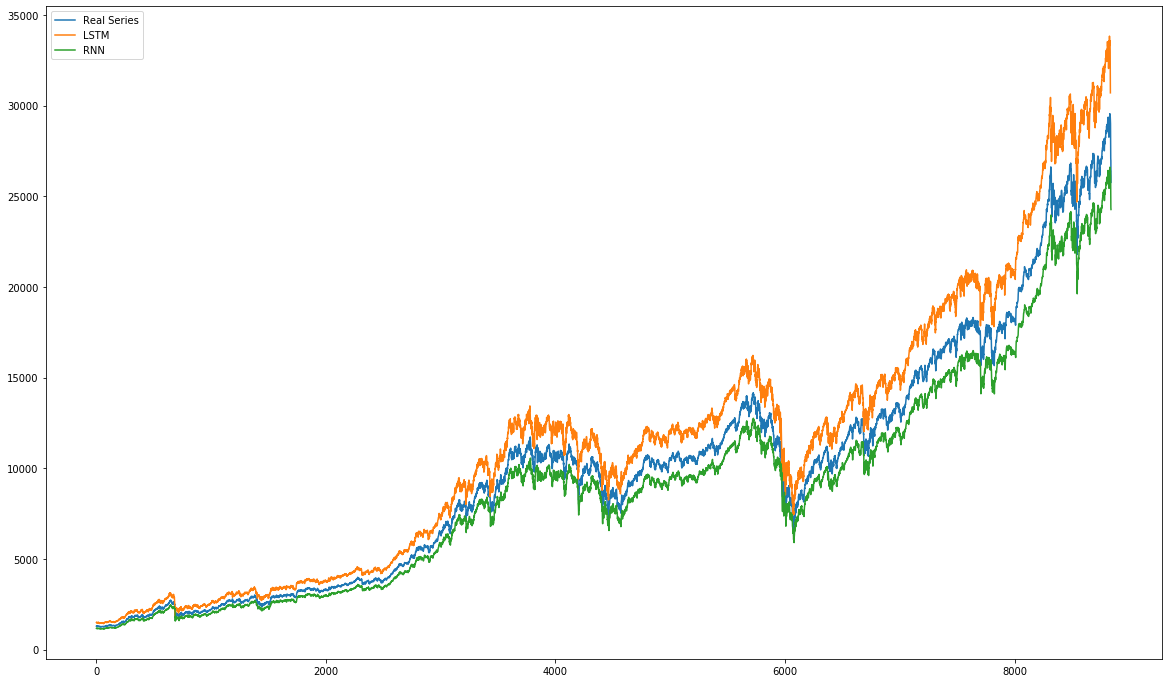

In [28]:
plt.figure(figsize=(20,12))
plt.plot(y_train, label='Real Series')
plt.plot(y_pred, label='LSTM')
plt.plot(y_pred_nn, label='RNN')
plt.legend()
print("MSE LSTM: {0:7.2f}".format((np.square(trainY - y_pred)).mean()))
print("MSE RMM: {0:7.2f}".format((np.square(y_train - y_pred_nn)).mean()))

### - GP

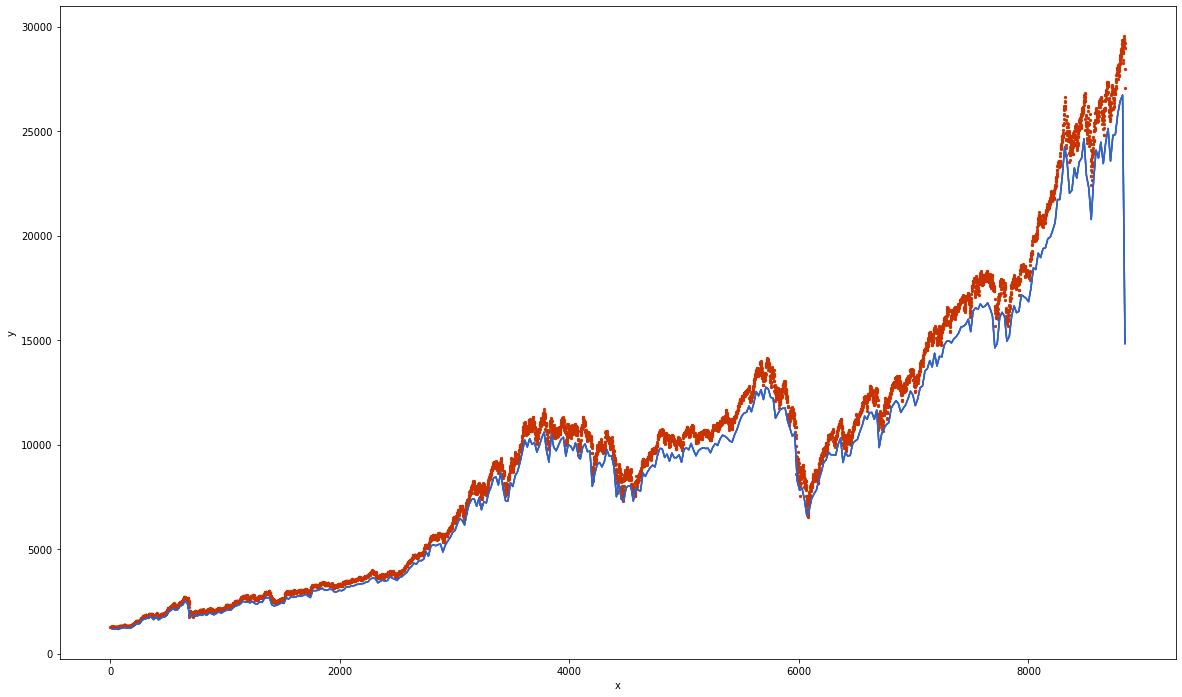

In [29]:
plt.figure(figsize=(20,12))
gp_predict(xc[:int(context_cnp.shape[0]/BATCH_SIZE)], yc[:int(context_cnp.shape[0]/BATCH_SIZE)], np.transpose([xt, yt]))

### - CNP

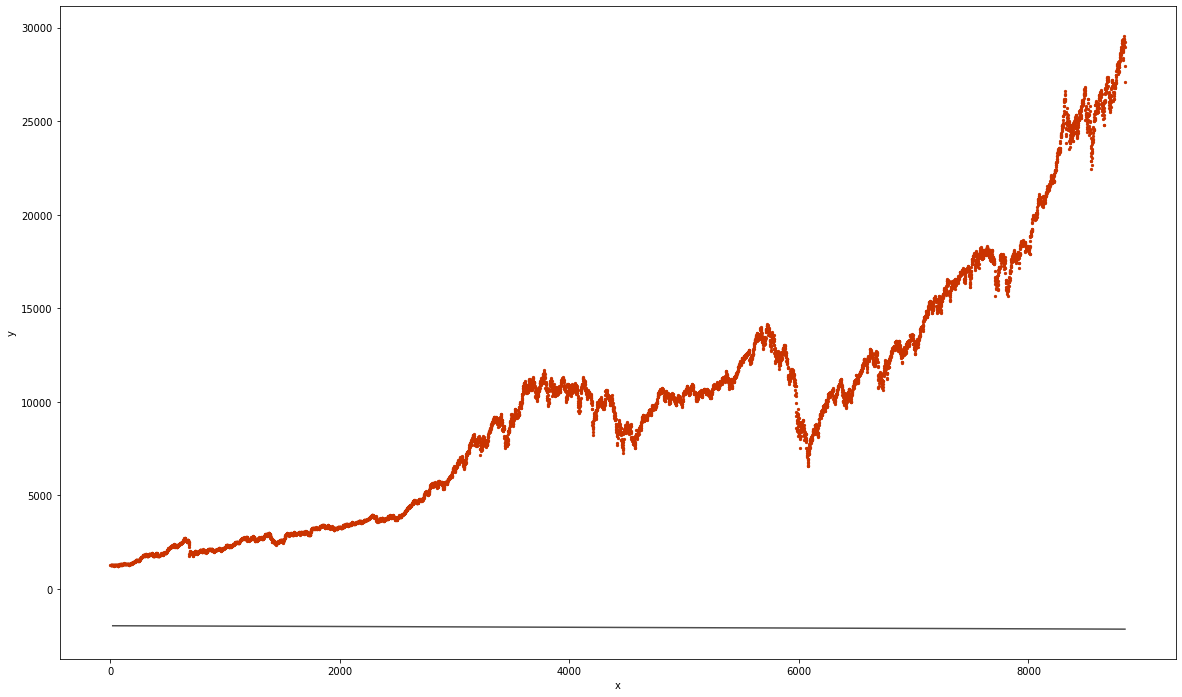

In [30]:
plt.figure(figsize=(20,12))
cnp_predict(xc[:int(context_cnp.shape[0]/BATCH_SIZE)], yc[:int(context_cnp.shape[0]/BATCH_SIZE)], np.transpose([xt, yt]))